### Importing Libraries

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.stats import mode
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_validate

### Importing Data

In [3]:
bigmart_train = pd.read_csv(r"D:\SQL\Time Series Forcasting\BigMart Sales Data\Train.csv")
bigmart_test = pd.read_csv(r"D:\SQL\Time Series Forcasting\BigMart Sales Data\Test.csv")

### Data

In [4]:
bigmart_train.sample(5)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
243,FDY56,16.35,Regular,0.062764,Fruits and Vegetables,227.6062,OUT017,2007,NaN,Tier 2,Supermarket Type1,7222.5984
4662,FDD38,16.75,Regular,0.008204,Canned,99.8674,OUT049,1999,Medium,Tier 1,Supermarket Type1,2342.9502
2489,FDK27,11.00,Low Fat,0.008960,Meat,119.1756,OUT049,1999,Medium,Tier 1,Supermarket Type1,1696.4584
3855,FDS16,15.15,Regular,0.066280,Frozen Foods,147.8760,OUT049,1999,Medium,Tier 1,Supermarket Type1,4540.7560
2443,NCB06,17.60,Low Fat,0.082264,Health and Hygiene,160.4920,OUT013,1987,High,Tier 3,Supermarket Type1,1278.3360


In [5]:
bigmart_train.isnull().sum() # Checking for null values

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [6]:
bigmart_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [7]:
bigmart_train.describe() # Statical analysis of numerical columns

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [8]:
X = bigmart_train.drop(columns=['Item_Outlet_Sales'])
y = bigmart_train['Item_Outlet_Sales']

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape

((5966, 11), (2557, 11))

### Data Wrangling+EDA+Feauture Engineering

In [10]:
X_train_c = X_train.copy()

In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5966 entries, 1921 to 7270
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            5966 non-null   object 
 1   Item_Weight                4943 non-null   float64
 2   Item_Fat_Content           5966 non-null   object 
 3   Item_Visibility            5966 non-null   float64
 4   Item_Type                  5966 non-null   object 
 5   Item_MRP                   5966 non-null   float64
 6   Outlet_Identifier          5966 non-null   object 
 7   Outlet_Establishment_Year  5966 non-null   int64  
 8   Outlet_Size                4276 non-null   object 
 9   Outlet_Location_Type       5966 non-null   object 
 10  Outlet_Type                5966 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 559.3+ KB


In [12]:
X_train_c.isnull().sum()

Item_Identifier                 0
Item_Weight                  1023
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1690
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [13]:
# Extracting all numeriacal columns from the data.

num_data = X_train_c.select_dtypes(exclude=['object'])
num_data.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
1921,7.72,0.147904,116.6466,1998
655,19.75,0.014301,103.0332,1997
2229,NaN,0.054221,129.1310,1985
2537,19.35,0.118342,222.6088,2002
3528,18.35,0.092150,184.8266,1987


In [14]:
num_data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
count,4943.000000,5966.000000,5966.000000,5966.000000
mean,12.937193,0.065821,141.814242,1997.867248
std,4.630433,0.051093,62.627609,8.385023
min,4.555000,0.000000,31.290000,1985.000000
25%,8.895000,0.026982,94.144250,1987.000000
50%,12.650000,0.053923,143.879900,1999.000000
75%,17.000000,0.094350,186.621400,2004.000000
max,21.350000,0.328391,266.888400,2009.000000


In [15]:
num_data.isnull().sum() # Null values in numerical data

Item_Weight                  1023
Item_Visibility                 0
Item_MRP                        0
Outlet_Establishment_Year       0
dtype: int64

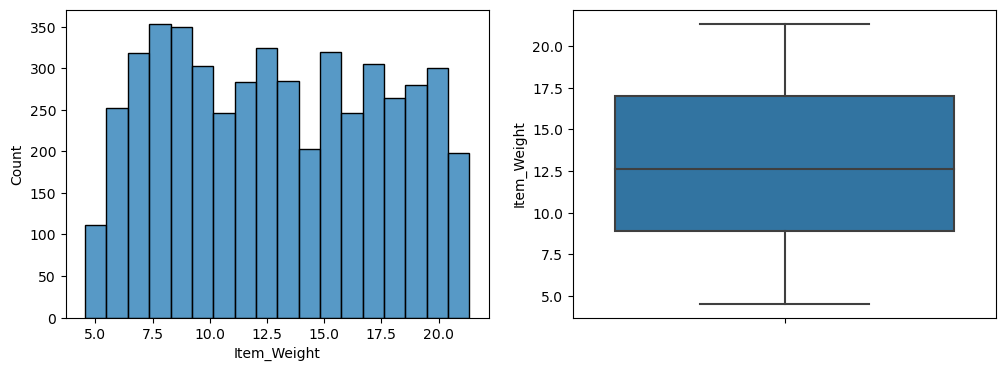

In [16]:
# Visualizing numerical data 

fig, ax = plt.subplots(1,2, figsize = (12,4))

sns.histplot(data = X_train_c, x='Item_Weight' , ax = ax[0]);
sns.boxplot(data = X_train_c, y='Item_Weight' , ax = ax[1]);

In [17]:
def visualize_num_feature(data_frame, col_name):
    fig, ax = plt.subplots(1,2, figsize = (12,4))
    sns.histplot(data = data_frame, x=col_name , ax = ax[0]);
    sns.boxplot(data = data_frame, y=col_name , ax = ax[1]);   

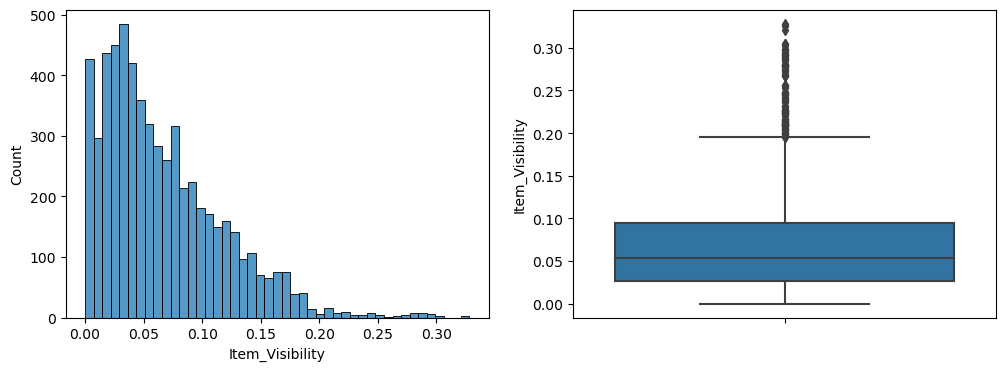

In [18]:
visualize_num_feature(X_train_c, 'Item_Visibility')

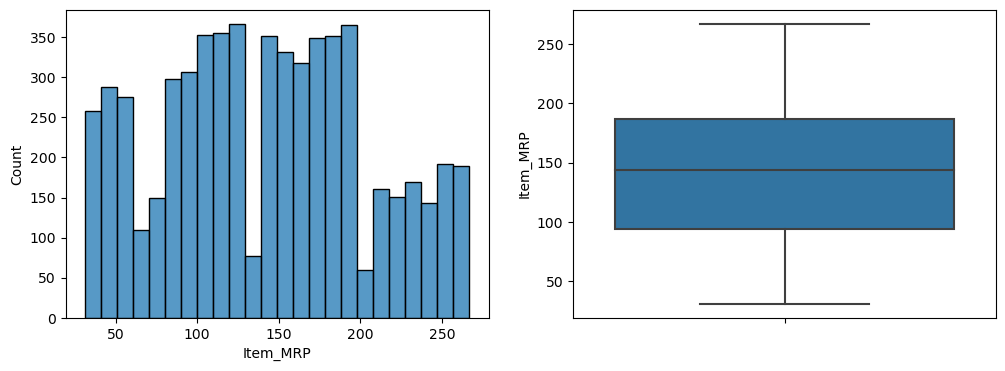

In [19]:
visualize_num_feature(X_train_c, 'Item_MRP')

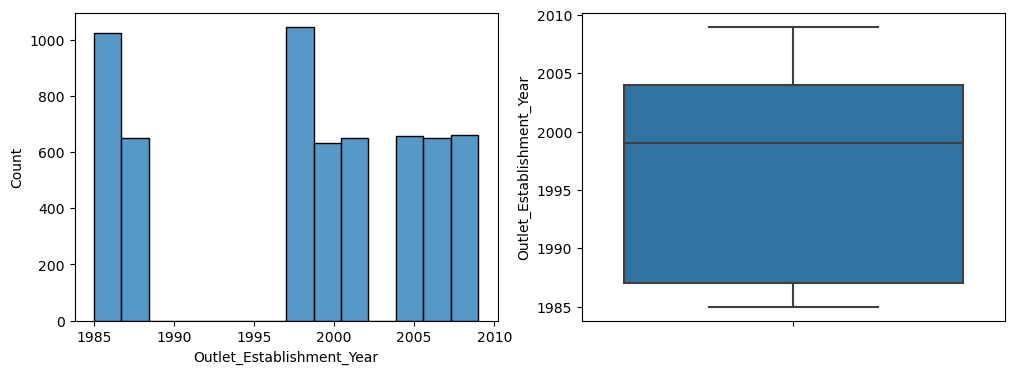

In [20]:
visualize_num_feature(X_train_c, 'Outlet_Establishment_Year')

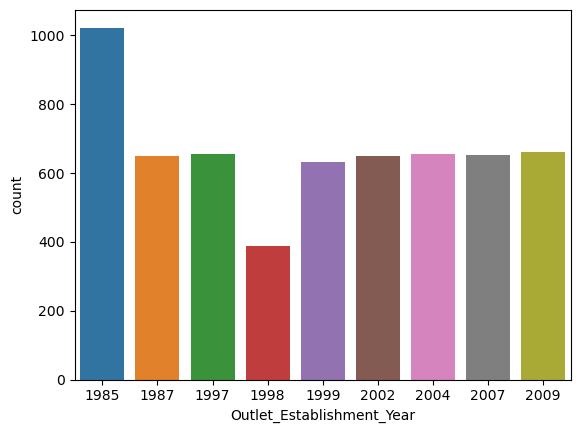

In [21]:
sns.countplot(data=X_train_c, x = 'Outlet_Establishment_Year');

In [22]:
cat_features = X_train_c.select_dtypes(include=['object'])
cat_features

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
1921,FDN08,Regular,Fruits and Vegetables,OUT010,NaN,Tier 3,Grocery Store
655,NCJ42,Low Fat,Household,OUT046,Small,Tier 1,Supermarket Type1
2229,FDY47,Regular,Breads,OUT027,Medium,Tier 3,Supermarket Type3
2537,FDN45,Low Fat,Snack Foods,OUT045,NaN,Tier 2,Supermarket Type1
3528,FDY16,Regular,Frozen Foods,OUT013,High,Tier 3,Supermarket Type1
...,...,...,...,...,...,...,...
5734,FDY08,Regular,Fruits and Vegetables,OUT010,NaN,Tier 3,Grocery Store
5191,FDC41,Low Fat,Frozen Foods,OUT017,NaN,Tier 2,Supermarket Type1
5390,NCQ53,Low Fat,Health and Hygiene,OUT045,NaN,Tier 2,Supermarket Type1
860,FDL46,low fat,Snack Foods,OUT017,NaN,Tier 2,Supermarket Type1


In [23]:
cat_features.describe() # Outlet_Size has some missing values

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
count,5966,5966,5966,5966,4276,5966,5966
unique,1543,5,16,10,3,3,4
top,NCI54,Low Fat,Fruits and Vegetables,OUT027,Medium,Tier 3,Supermarket Type1
freq,9,3535,905,668,1960,2367,3893


In [24]:
cat_features.isnull().sum()

Item_Identifier            0
Item_Fat_Content           0
Item_Type                  0
Outlet_Identifier          0
Outlet_Size             1690
Outlet_Location_Type       0
Outlet_Type                0
dtype: int64

In [25]:
cat_features['Item_Identifier'].value_counts() # Shows the number of rows of data for each category in Item_Identifier column

Item_Identifier
NCI54    9
FDF52    9
FDV60    8
FDT07    8
NCB18    8
        ..
FDT47    1
NCW42    1
DRH59    1
FDV14    1
FDG28    1
Name: count, Length: 1543, dtype: int64

In [26]:
cat_features['Item_Fat_Content'].value_counts() # Some inconsentensis as 'Low fat' & 'Regular' are mentioned in different ways

Item_Fat_Content
Low Fat    3535
Regular    2027
LF          243
low fat      82
reg          79
Name: count, dtype: int64

In [27]:
cat_features['Item_Type'].value_counts()

Item_Type
Fruits and Vegetables    905
Snack Foods              835
Household                648
Frozen Foods             591
Dairy                    474
Canned                   450
Baking Goods             438
Health and Hygiene       365
Soft Drinks              305
Meat                     275
Hard Drinks              162
Breads                   159
Others                   124
Starchy Foods            116
Breakfast                 80
Seafood                   39
Name: count, dtype: int64

In [28]:
cat_features['Outlet_Identifier'].value_counts()

Outlet_Identifier
OUT027    668
OUT018    661
OUT046    656
OUT035    656
OUT017    652
OUT045    649
OUT013    649
OUT049    631
OUT010    389
OUT019    355
Name: count, dtype: int64

In [29]:
cat_features['Outlet_Size'].value_counts()

Outlet_Size
Medium    1960
Small     1667
High       649
Name: count, dtype: int64

In [30]:
cat_features['Outlet_Location_Type'].value_counts()

Outlet_Location_Type
Tier 3    2367
Tier 2    1957
Tier 1    1642
Name: count, dtype: int64

In [31]:
cat_features['Outlet_Type'].value_counts() 

Outlet_Type
Supermarket Type1    3893
Grocery Store         744
Supermarket Type3     668
Supermarket Type2     661
Name: count, dtype: int64

In [32]:
#X_train_c['Item_Identifier'].apply(lambda x:x[:2]).value_counts() # will show first 2 characters 
X_train_c['Item_Identifier'].str[:2].value_counts() 

Item_Identifier
FD    4269
NC    1137
DR     560
Name: count, dtype: int64

In [33]:
def create_item_type(data_frame):
    data_frame['Item_Type'] = data_frame['Item_Identifier'].str[:2]
    data_frame['Item_type'] = data_frame['Item_Type'].map({'FD' : 'Food',
                                                           'NC' : 'Non_Consumables',
                                                           'DR' : 'Drink'
                                                          })
    return data_frame

In [34]:
X_train_c = create_item_type(X_train_c)
X_train_c.sample(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_type
2290,FDV09,12.10,Low Fat,0.020652,FD,149.5734,OUT018,2009,Medium,Tier 3,Supermarket Type2,Food
3061,FDH26,19.25,Regular,0.034693,FD,140.1496,OUT035,2004,Small,Tier 2,Supermarket Type1,Food
5173,FDU51,20.20,Regular,0.097060,FD,178.6028,OUT017,2007,NaN,Tier 2,Supermarket Type1,Food


In [35]:
X_train_c[['Item_Identifier', 'Item_Weight']].drop_duplicates().sort_values(by= ['Item_Identifier']).head(10)

,Item_Identifier,Item_Weight
1245,DRA12,11.600
4900,DRA24,19.350
6057,DRA59,NaN
1876,DRA59,8.270
3733,DRB01,NaN
3571,DRB01,7.390
1431,DRB13,6.115
2657,DRB24,8.785
2533,DRB25,NaN
776,DRB25,12.300


In [36]:
X_train_c[['Item_Type', 'Item_Weight']].drop_duplicates().sort_values(by = ['Item_Type']).head(5)

,Item_Type,Item_Weight
2796,DR,5.730
998,DR,20.250
670,DR,8.395
6091,DR,13.500
3438,DR,13.850


In [37]:
# Filling in the missing values for 'Item_Weight'
# Logic
# Use mapping of 'item_ID' weight 
# If it is completly new item, not present in test\live data then use median to fill in the missing values

ITEM_ID_WEIGHT_PIVOT = X_train_c.pivot_table(values='Item_Weight' , index='Item_Identifier').reset_index()
ITEM_ID_WEIGHT_MAPPING = dict(zip(ITEM_ID_WEIGHT_PIVOT['Item_Identifier'], ITEM_ID_WEIGHT_PIVOT['Item_Weight']))
list(ITEM_ID_WEIGHT_MAPPING.items())[:10]

[('DRA12', 11.6),
 ('DRA24', 19.35),
 ('DRA59', 8.27),
 ('DRB01', 7.39),
 ('DRB13', 6.115),
 ('DRB24', 8.785),
 ('DRB25', 12.300000000000002),
 ('DRB48', 16.75),
 ('DRC01', 5.92),
 ('DRC12', 17.85)]

In [38]:
ITEM_TYPE_WEIGHT_PIVOT = X_train_c.pivot_table(values='Item_Weight' , index='Item_Type' , aggfunc='median').reset_index()
ITEM_TYPE_WEIGHT_MAPPING = dict(zip(ITEM_TYPE_WEIGHT_PIVOT['Item_Type'], ITEM_TYPE_WEIGHT_PIVOT['Item_Weight']))
ITEM_TYPE_WEIGHT_MAPPING.items()

dict_items([('DR', 11.8), ('FD', 12.8), ('NC', 13.05)])

In [39]:
def impute_item_weight(data_frame):
    # Item ID - weight
    data_frame.loc[:, 'Item_Weight'] = data_frame.loc[:, 'Item_Weight'].fillna(data_frame.loc[:, 'Item_Identifier'].map(ITEM_ID_WEIGHT_MAPPING))

# Item Type - Weight 
    data_frame.loc[:, 'Item_Weight'] = data_frame.loc[:, 'Item_Weight'].fillna(data_frame.loc[:, 'Item_Type'].map(ITEM_TYPE_WEIGHT_MAPPING))

    return data_frame



In [40]:
X_train_c = impute_item_weight(X_train_c)

In [41]:
X_train_c.isnull().sum() # No null values for Item_Weight

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1690
Outlet_Location_Type            0
Outlet_Type                     0
Item_type                       0
dtype: int64

In [42]:
# FIlling in missing values for 'Outlet_Size'
# X_train_c.groupby(by = ['Outlet_Type', 'Outlet_Size']).size() 

Outlet_Type        Outlet_Size
Grocery Store      Small           355
Supermarket Type1  High            649
                   Medium          631
                   Small          1312
Supermarket Type2  Medium          661
Supermarket Type3  Medium          668
dtype: int64

In [46]:
# FIlling null values in Outlet_size

imputer = SimpleImputer(strategy='most_frequent')
Outlet_Size_fill = ['Outlet_Size']
X_train_c[Outlet_Size_fill] = imputer.fit_transform(X_train_c[Outlet_Size_fill])

In [51]:
X_train_c.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_type                    0
dtype: int64

In [52]:
X_train_c['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    3535
Regular    2027
LF          243
low fat      82
reg          79
Name: count, dtype: int64

In [53]:
# standardize 'Item_fat_content' column

def standardize_item_fat_content(data_frame):
    data_frame['Item_Fat_Content'] = data_frame['Item_Fat_Content'].replace({'Low Fat' : 'Low_Fat',
                                                                                'LF': 'Low_Fat',
                                                                                'reg': 'Regular',
                                                                                'low fat': 'Low_Fat'
                                                                                })
    
    return data_frame

In [54]:
X_train_c = standardize_item_fat_content(X_train_c)
X_train_c['Item_Fat_Content'].value_counts()


Item_Fat_Content
Low_Fat    3860
Regular    2106
Name: count, dtype: int64

In [55]:
# Non-consumable item cannot be low fat, will change 
X_train_c.groupby(by = ['Item_Type', 'Item_Fat_Content']).size()

Item_Type  Item_Fat_Content
DR         Low_Fat              517
           Regular               43
FD         Low_Fat             2206
           Regular             2063
NC         Low_Fat             1137
dtype: int64

In [56]:
X_train_c.loc[X_train_c['Item_type'] == 'NC', 'Item_Fat_Content']

Series([], Name: Item_Fat_Content, dtype: object)

In [57]:
def correct_item_fat_content(data_frame):
    data_frame.loc[data_frame['Item_Type'] == 'Non_Consumables', 'Item_Fat_Content'] = 'Non_Edible'
    
    return data_frame

In [58]:
X_train_c = correct_item_fat_content(X_train_c)

In [59]:
X_train_c.groupby(by= ['Item_Type', 'Item_Fat_Content']).size()

Item_Type  Item_Fat_Content
DR         Low_Fat              517
           Regular               43
FD         Low_Fat             2206
           Regular             2063
NC         Low_Fat             1137
dtype: int64

In [64]:
X_train_c['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low_Fat    3860
Regular    2106
Name: count, dtype: int64

In [65]:
X_train_c.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5966 entries, 1921 to 7270
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            5966 non-null   object 
 1   Item_Weight                5966 non-null   float64
 2   Item_Fat_Content           5966 non-null   object 
 3   Item_Visibility            5966 non-null   float64
 4   Item_Type                  5966 non-null   object 
 5   Item_MRP                   5966 non-null   float64
 6   Outlet_Identifier          5966 non-null   object 
 7   Outlet_Establishment_Year  5966 non-null   int64  
 8   Outlet_Size                5966 non-null   object 
 9   Outlet_Location_Type       5966 non-null   object 
 10  Outlet_Type                5966 non-null   object 
 11  Item_type                  5966 non-null   object 
dtypes: float64(3), int64(1), object(8)
memory usage: 605.9+ KB


### Preperaing data for ML

In [74]:
def prepare_dataset(data_frame):
    data_frame = create_item_type(data_frame)
    data_frame = impute_item_weight(data_frame)
    data_frame = standardize_item_fat_content(data_frame)
    data_frame = correct_item_fat_content(data_frame)
    return data_frame

In [87]:
X_train = prepare_dataset(X_train)

In [88]:
# FIlling null values in Outlet_size training data

imputer = SimpleImputer(strategy='most_frequent')
Outlet_Size_train = ['Outlet_Size']
X_train[Outlet_Size_train] = imputer.fit_transform(X_train[Outlet_Size_train])

In [89]:
X_train.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_type                    0
dtype: int64

In [90]:
X_test = prepare_dataset(X_test)

In [91]:
# FIlling null values in Outlet_size test data

imputer = SimpleImputer(strategy='most_frequent')
Outlet_Size_test = ['Outlet_Size']
X_test[Outlet_Size_test] = imputer.fit_transform(X_test[Outlet_Size_test])

In [92]:
X_test.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_type                    0
dtype: int64

### Applying onehot encoding in all category columns 

In [95]:
cat_feats = X_train.select_dtypes(include='object')
cat_feats

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_type
1921,FDN08,Regular,FD,OUT010,Medium,Tier 3,Grocery Store,Food
655,NCJ42,Low_Fat,NC,OUT046,Small,Tier 1,Supermarket Type1,Non_Consumables
2229,FDY47,Regular,FD,OUT027,Medium,Tier 3,Supermarket Type3,Food
2537,FDN45,Low_Fat,FD,OUT045,Medium,Tier 2,Supermarket Type1,Food
3528,FDY16,Regular,FD,OUT013,High,Tier 3,Supermarket Type1,Food
...,...,...,...,...,...,...,...,...
5734,FDY08,Regular,FD,OUT010,Medium,Tier 3,Grocery Store,Food
5191,FDC41,Low_Fat,FD,OUT017,Medium,Tier 2,Supermarket Type1,Food
5390,NCQ53,Low_Fat,NC,OUT045,Medium,Tier 2,Supermarket Type1,Non_Consumables
860,FDL46,Low_Fat,FD,OUT017,Medium,Tier 2,Supermarket Type1,Food


In [96]:
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(cat_feats)

OneHotEncoder(handle_unknown='ignore')

In [100]:
ohe_feature_names = ohe.get_feature_names_out(input_features=cat_feats.columns)

In [106]:
ohe_feature_names

array(['Item_Identifier_DRA12', 'Item_Identifier_DRA24',
       'Item_Identifier_DRA59', ..., 'Item_type_Drink', 'Item_type_Food',
       'Item_type_Non_Consumables'], dtype=object)

In [107]:
num_data_train = X_train.select_dtypes(exclude='object').reset_index(drop=True)

In [108]:
num_data_train.sample(4)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
5843,10.30,0.030569,113.1176,1997
5099,18.00,0.079299,170.5422,1998
3692,15.35,0.035143,124.3730,2004
5583,16.75,0.075369,35.2532,1985


In [109]:
cat_feats_train = X_train.select_dtypes(include='object')
X_train_cat_ohe = pd.DataFrame(ohe.transform(cat_feats_train).toarray(), columns=ohe_feature_names)

In [113]:
X_train_cat_ohe.head()

,Item_Identifier_DRA12,Item_Identifier_DRA24,Item_Identifier_DRA59,Item_Identifier_DRB01,Item_Identifier_DRB13,Item_Identifier_DRB24,Item_Identifier_DRB25,Item_Identifier_DRB48,Item_Identifier_DRC01,Item_Identifier_DRC12,...,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_type_Drink,Item_type_Food,Item_type_Non_Consumables
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [115]:
X_train_final = pd.concat([num_data_train, X_train_cat_ohe], axis=1)
X_train_final.head(5)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Identifier_DRA12,Item_Identifier_DRA24,Item_Identifier_DRA59,Item_Identifier_DRB01,Item_Identifier_DRB13,Item_Identifier_DRB24,...,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_type_Drink,Item_type_Food,Item_type_Non_Consumables
0,7.72,0.147904,116.6466,1998,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,19.75,0.014301,103.0332,1997,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,8.60,0.054221,129.1310,1985,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,19.35,0.118342,222.6088,2002,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,18.35,0.092150,184.8266,1987,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [117]:
final_columns = X_train_final.columns.values
final_columns

array(['Item_Weight', 'Item_Visibility', 'Item_MRP', ...,
       'Item_type_Drink', 'Item_type_Food', 'Item_type_Non_Consumables'],
      dtype=object)

In [121]:
# For test data

num_feats_test = X_test.select_dtypes(exclude='object').reset_index(drop=True)
cat_feats_test = X_test.select_dtypes(include='object')
X_test_cat_ohe = pd.DataFrame(ohe.transform(cat_feats_test).toarray(), columns=ohe_feature_names)
X_test_final = pd.concat([num_feats_test, X_test_cat_ohe], axis=1)
X_test_final.head()

### Modelling